In [2]:
from summac.model_summac import SummaCConv
from tqdm.notebook import tqdm
import numpy as np
import json
import torch

c:\Users\theav\miniconda3\envs\modelfinetune_factuality\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [3]:
#check cuda
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
models = ['samsum_bart_base', 'samsum_bart_cleaned', 'samsum_bart_custom_tokenizer', 'samsum_bart_oov', 'samsum_bart_wsd', 'samsum_bart_wsd_custom_tokenizer', 'samsum_bart_oov_custom_tokenizer']

In [5]:
#load the summaries
summaries = {}
for model in models:
    with open(f"../models/{model}/summaries.json", "r") as f:
        summaries[model] = json.load(f)

In [6]:
model_conv = SummaCConv(models=["vitc"], bins='percentile', granularity="sentence", nli_labels="e", device="cuda", start_file="default", agg="mean")

<All keys matched successfully>


c:\Users\theav\miniconda3\envs\modelfinetune_factuality\Lib\site-packages\summac\model_summac.py:250: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  print(self.load_state_dic

In [7]:

scores = {}
bar =  tqdm(models)
for model in bar:
    bar.set_description(f"Computing SummaC Scores for model {model}")
    amt_summaries = len(summaries[model]['summary'])
    
    scores[model] = {'true_summary_score': [], 'generated_summary_score': []}
    scores[model]['true_summary_scores'] = model_conv.score(summaries[model]['dialogue'], summaries[model]['summary'])['scores']
    scores[model]['generated_summary_scores'] = model_conv.score(summaries[model]['dialogue'], summaries[model]['generated_summaries'])['scores']

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\theav\miniconda3\envs\modelfinetune_factuality\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\theav\miniconda3\envs\modelfinetune_factuality\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\theav\miniconda3\envs\modelfinetune_factuality\Lib\site-packages\summac\model_summac.py:298: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  histogr

In [6]:
#load the scores from disk
with open("../models/samsum_summac_scores.json", 'r') as f:
    scores = json.load(f)

In [15]:
#save the summac scores to disk
def save_scores():
    import json
    with open('../models/samsum_summac_scores.json', 'w') as f:
        json.dump(scores, f)

In [8]:
_model = "samsum_bart_wsd_custom_tokenizer"
scores[_model] = {'true_summary_score': [], 'generated_summary_score': []}
scores[_model]['true_summary_scores'] = model_conv.score(summaries[_model]['dialogue'], summaries[_model]['summary'])['scores']
scores[_model]['generated_summary_scores'] = model_conv.score(summaries[_model]['dialogue'], summaries[_model]['generated_summaries'])['scores']

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

In [67]:

np.mean(scores['samsum_bart_custom_tokenizer']['generated_summary_scores'])

np.float64(0.3450393845783194)

In [10]:
# Create DataFrames for the scores
def plot_scores(scores, model_name):
    df_true = pd.DataFrame(scores[model_name]['true_summary_scores'], columns=["True Summary"])
    df_generated = pd.DataFrame(scores[model_name]['generated_summary_scores'], columns=["Generated Summary"])

    # Calculate the mean scores
    mean_true = df_true['True Summary'].mean()
    mean_generated = df_generated['Generated Summary'].mean()

    # Plot the KDEs on the same plot
    ax = df_true.plot(kind="kde", color='blue', linestyle='-', label='True Summary', legend=True)
    df_generated.plot(kind="kde", ax=ax, color='red', linestyle='--', label='Generated Summary', legend=True)

    # Add vertical lines for the mean scores
    plt.axvline(mean_true, color='blue', linestyle='-', linewidth=1)
    plt.axvline(mean_generated, color='red', linestyle='--', linewidth=1)

    # Add text labels next to the vertical lines
    plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.8, f'Mean: {mean_true:.3f}', color='blue', rotation=0, va='top', ha='right')
    plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.7, f'Mean: {mean_generated:.3f}', color='red', rotation=0, va='top', ha='right')

    # Add labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'KDE of True and Generated Summary Scores for {model_name}')
    plt.grid(True)

    # Show the plot
    plt.show()

In [42]:
def plot_scores_2(scores, model_names):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    
    for model in model_names:
        df_generated = pd.DataFrame(scores[model]['generated_summary_scores'], columns=[model])

        # Calculate the mean scores
        mean_generated = df_generated[model].mean()

        # Plot the KDEs on the same plot
        df_generated.plot(kind="kde", ax=ax, label=model, legend=True)

        # Add vertical lines for the mean scores
        # plt.axvline(mean_true, color='blue', linestyle='-', linewidth=1)
        # plt.axvline(mean_generated, color='red', linestyle='--', linewidth=1)

    # Add text labels next to the vertical lines
    # plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.8, f'Mean: {mean_true:.2f}', color='blue', rotation=0, va='top', ha='right')
    # plt.text(plt.gca().get_xlim()[1]*0.95, plt.gca().get_ylim()[1]*0.7, f'Mean: {mean_generated:.2f}', color='red', rotation=0, va='top', ha='right')

    # Add labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Distribution of SummaC Scores for Generated Summaries')
    plt.grid(True)

    # Show the plot
    plt.show()

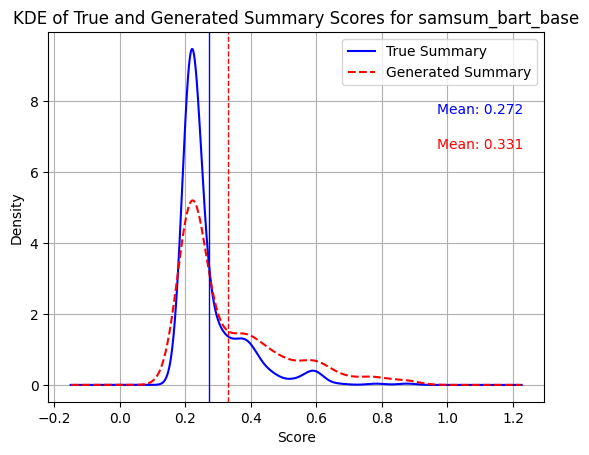

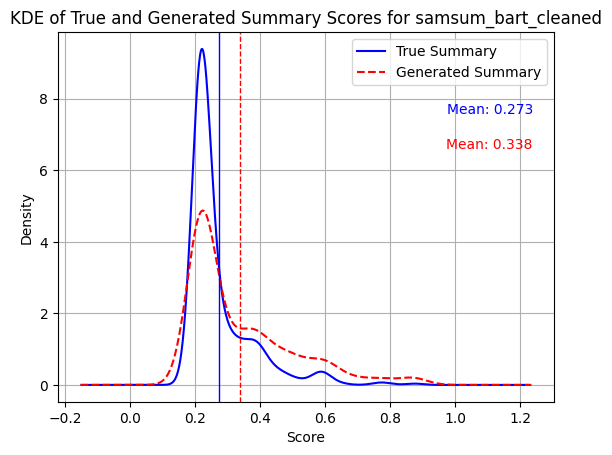

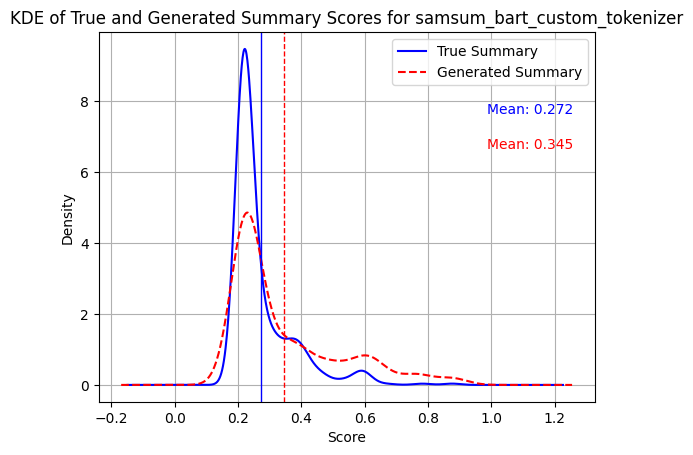

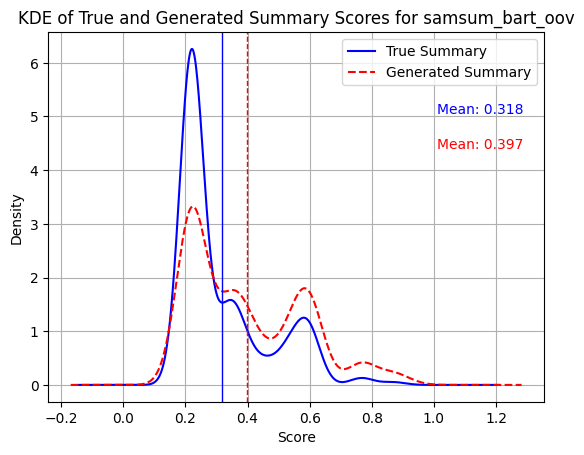

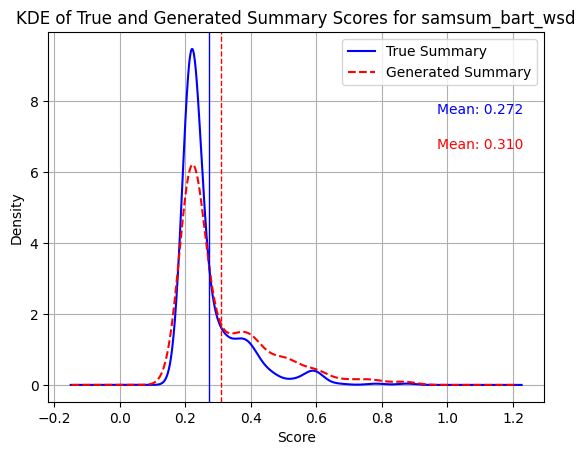

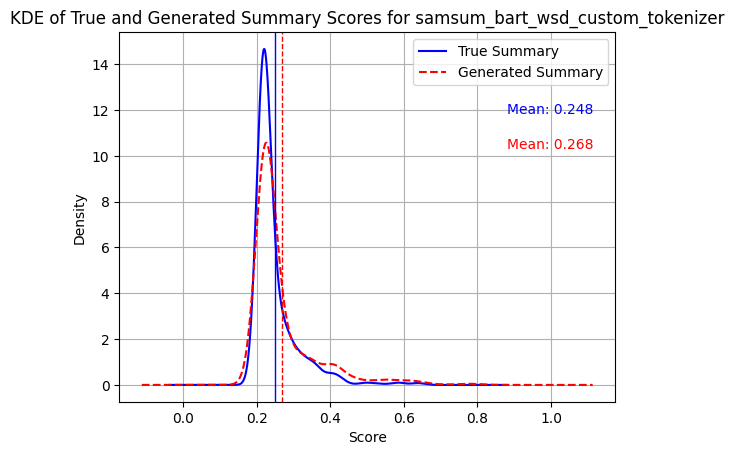

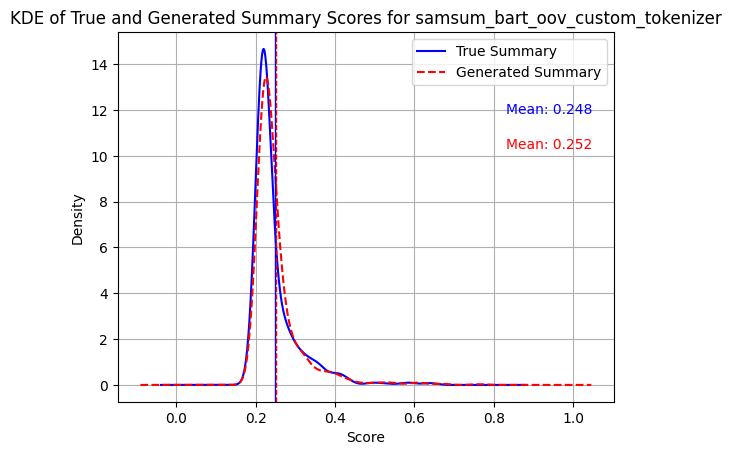

In [12]:
for model in models:
    plot_scores(scores, model)

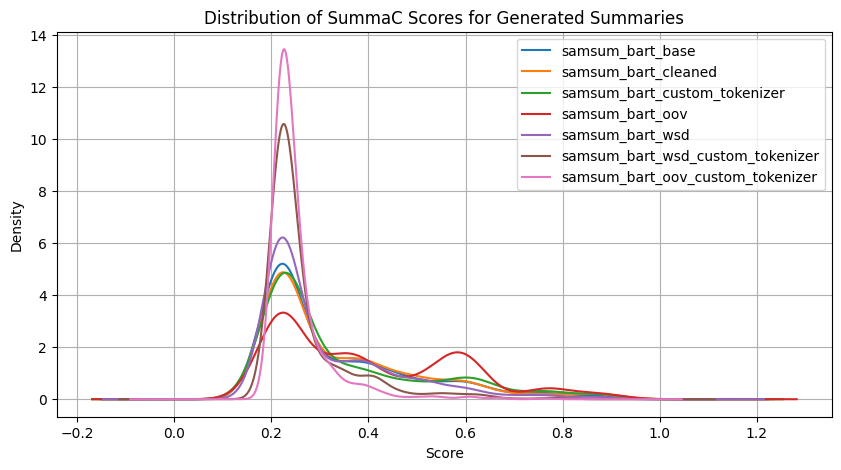

In [45]:
plot_scores_2(scores, models)

In [18]:
import pandas as pd
from scipy.stats import ttest_ind

In [16]:
generated_scores = {model: scores[model]['generated_summary_scores'] for model in scores}
scores_df = pd.DataFrame(generated_scores)

In [26]:
scores_df.agg(['mean', 'std']).transpose().to_latex(buf="summac.tex")

In [20]:
def t_test_matrix_summac(models):
    t_test_results = []
    base_model = 'samsum_bart_base'

    for model in models:
        if model != base_model:
        
            # Extract ROUGE-1 F1 scores for the base model and the current model
            base_scores = scores_df[base_model].dropna()
            model_scores = scores_df[model].dropna()
            
            # Ensure that both series have the same length
            # If not, align them by index or handle accordingly
            min_length = min(len(base_scores), len(model_scores))
            base_scores = base_scores.iloc[:min_length]
            model_scores = model_scores.iloc[:min_length]
            
            # Perform the independent t-test (Welch's t-test)
            _, p_value = ttest_ind(base_scores, model_scores, equal_var=False)
            
            # Append the results to the list
            t_test_results.append({
                'Model': model,
                'P-value': p_value
            })

    # Create a DataFrame from the t-test results
    t_test_df = pd.DataFrame(t_test_results)

    return t_test_df

In [21]:
t_test_df = t_test_matrix_summac(models)

In [28]:
t_test_df

,Model,P-value
0,samsum_bart_cleaned,3.324182e-01
1,samsum_bart_custom_tokenizer,8.074693e-02
2,samsum_bart_oov,1.256589e-14
3,samsum_bart_wsd,5.697193e-03
4,samsum_bart_wsd_custom_tokenizer,2.805050e-22
5,samsum_bart_oov_custom_tokenizer,6.917723e-37


In [27]:
t_test_df.to_latex(index=False, buf="summac_ttest.tex")

In [33]:
summaries_01 = {model: summaries[model]['generated_summaries'][0] for model in summaries}
dialogues_01 = {model: summaries[model]['dialogue'][0] for model in summaries}

In [35]:


example_results_df = pd.DataFrame([summaries_01, dialogues_01])

In [41]:
example_results_df.transpose().rename(columns={0: 'Summary', 1: 'Dialogue'})[['Dialogue', 'Summary']].to_latex("example_summaries.tex")